In [1]:
from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping
from jax import vmap

jax.config.update("jax_enable_x64", True)


In [2]:
# Represents the interval [x0, x_final] discretised into n equally-spaced points.
class SpatialDiscretisation(eqx.Module):
    xmin: float = eqx.field(static=True)
    xmax: float = eqx.field(static=True)
    ymin: float = eqx.field(static=True)
    ymax: float = eqx.field(static=True)
    vals: Float[Array, "nx ny"]

    @classmethod
    def discretise_fn(cls, 
                      xmin: float, xmax: float, 
                      ymin: float, ymax:float,
                      nx: int, ny:int,
                      fn: Callable):
        """
        fn : must be a function with separated inputs f(x, y)
        """

        if nx < 2:
            raise ValueError("Must discretise [xmin, xmax] into at least two points")
        elif ny < 2:
            raise ValueError("Must discretise [ymin, ymax] into at least two points")

        # WARNING: meshgrid transposes by default, xv and yv are (ny, nx).
        # Set indexing="ij" for (nx, ny) shape
        xv, yv = jnp.meshgrid(jnp.linspace(xmin, xmax, nx),
                              jnp.linspace(ymin, ymax, ny),
                              indexing="ij"
                             )
        vals = vmap(fn)(jnp.vstack([xv.flatten(), yv.flatten()]).T).reshape(xv.shape) 
        return cls(xmin, xmax, ymin, ymax, vals)

    @property
    def δx(self):
        return (self.xmax - self.xmin) / (self.vals.shape[0] - 1)
    
    @property
    def δy(self):
        return (self.ymax - self.ymin) / (self.vals.shape[1] - 1)


    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            if self.xmin != other.xmin or self.xmax != other.xmax:
                raise ValueError("Mismatched x-axis spatial discretisations")
            if self.ymin != other.ymin or self.ymax != other.ymax:
                raise ValueError("Mismatched y-axis spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(self.xmin, self.xmax, self.ymin, self.ymax, fn(self.vals, other))

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)


def laplacian(y: SpatialDiscretisation) -> SpatialDiscretisation:

    # Pick one kernel for discrete laplacian
    # this works...
    dx2, dy2 = 1, 1
    # .. and this does not
    # dx2, dy2 = y.δx**2, y.δy**2 

    # Sol 1) Everything in 1 convolution : numerically instable if dx2 or dy2 !=1
    lap_kernel = jnp.array([[0, -dx2, 0], [-dy2, 2*(dx2 + dy2), -dy2], [0, -dx2, 0]])
    Δy = jax.scipy.signal.convolve(y.vals, lap_kernel, mode='same') / (dx2 * dy2)
    
    # Sol 2) try two convolution ? Also instable
    # lap_kernel_x = jnp.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]]) # horizontal 2nd order diff
    # lap_kernel_y = lap_kernel_x.T # vertical 2nd order diff
    # Δy_x = jax.scipy.signal.convolve(y.vals, lap_kernel_x, mode='same') / dx2 
    # Δy_y = jax.scipy.signal.convolve(y.vals, lap_kernel_y, mode='same') / dy2
    # Δy = Δy_x + Δy_y
    
    # Dirichlet boundary condition
    Δy = Δy.at[0, :].set(0)
    Δy = Δy.at[-1, :].set(0)
    Δy = Δy.at[:, 0].set(0)
    Δy = Δy.at[:, -1].set(0)

    return SpatialDiscretisation(y.xmin, y.xmax, y.ymin, y.ymax, Δy)




I0000 00:00:1696349391.953330  104405 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(768, 1024)
(768, 1024)
(768, 1024)


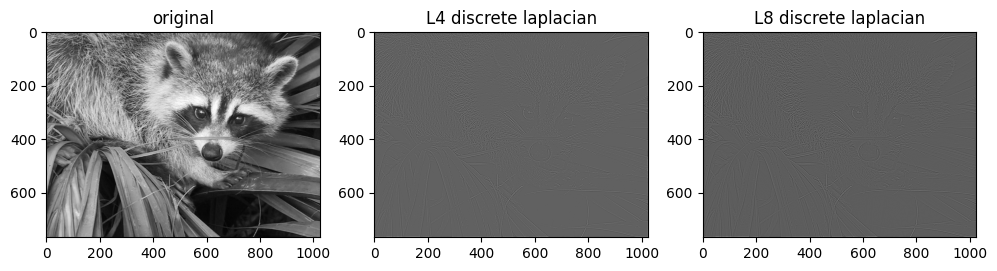

In [3]:
# test convolution with L4 or L8 on an image
# from scipy.datasets import face
# import jax.scipy as jsp

# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# # Load a sample image; compute mean() to convert from RGB to grayscale.
# image = jnp.array(face().mean(-1))
# ax[0].imshow(image, cmap='binary_r')
# ax[0].set_title('original')

# L4_kernel = jnp.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
# L8_kernel = jnp.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# smooth_image_l4 = jsp.signal.convolve(image, L4_kernel, mode='same')
# smooth_image_l8 = jsp.signal.convolve(image, L8_kernel, mode='same')

# ax[1].imshow(smooth_image_l4, cmap ='binary_r')
# ax[1].set_title('L4 discrete laplacian')

# ax[2].imshow(smooth_image_l8, cmap ='binary_r')
# ax[2].set_title('L8 discrete laplacian')

# print(image.shape)
# print(smooth_image_l4.shape)
# print(smooth_image_l8.shape)

In [4]:
# ###############
# # Test vmap
# # over an image
# ##############

# import jax.numpy as jnp
# from jax import vmap
# def f(xy):
#     print(xy)
#     return xy.sum()

# x = jnp.linspace(0, 1, 10)
# y = jnp.linspace(1, 2, 5)
# xv, yv = jnp.meshgrid(x, y, indexing='ij')
# print("meshgrid() transposes to get an 'image' (ny, nx). Need to set indexing='ij' to get (nx, ny) shape.")
# print(xv.shape, yv.shape)
# vmap(f)(jnp.vstack([xv.flatten(), yv.flatten()]).T).reshape(xv.shape) 

[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


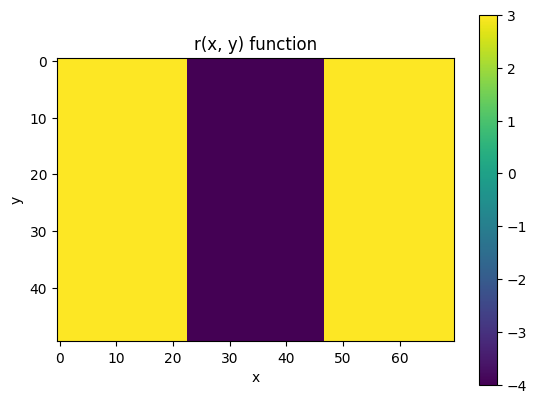

In [5]:
import numpy as np

# Spatial discretisation
xmin, xmax = 0, 1
ymin, ymax = 0, 1
nx, ny = 70, 50

# Function that defines the frontiers of Omega in terms of "r" values
def r_func(x, y):
    r_good = np.array(3)
    r_bad = np.array(-4)
    if x < 1/3 or x > 2/3:
        return r_good
    else:
        return r_bad
    # cond = jnp.logical_or(x < 1/3, x > 2/3)
    # print(cond.sum())
    # return jax.lax.cond(cond, lambda operands: r_good, lambda operands: r_bad)

xv, yv = jnp.meshgrid(jnp.linspace(xmin, xmax, nx),
                      jnp.linspace(ymin, ymax, ny),
                      indexing="ij"
                     )
r_mat = np.vectorize(r_func)(xv, yv)
r_mat = jnp.array(r_mat)
plt.imshow(r_mat.T)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("r(x, y) function")
print(r_mat) 

# set gamma
gamma = 1


# initial condition
mu_init = jnp.array([0.5, 0.5])
def gauss_ic(xy):
    return jnp.exp(-jnp.linalg.norm(xy - mu_init))
    # return jnp.min(jnp.array(0.2), jnp.exp(-jnp.linalg.norm(xy - mu_init)))

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, gauss_ic)

# set vector field
def vector_field(t, y, args):
    return laplacian(y) + r_mat * y - gamma * y * y

# Prepare ODE object on discretized problem
term = diffrax.ODETerm(vector_field)


# Temporal discretisation
t0 = 0
t_final = 1
δt = 0.0001
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t_final, 30))

# Tolerances
rtol = 1e-10
atol = 1e-10
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=0.001
)


In [6]:
solver = diffrax.Tsit5()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

sol.ys.vals.shape
sol.ts

NameError: name 'Δy_x' is not defined

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

nplot = 5
t_ind = jnp.floor(jnp.linspace(0, len(sol.ts), nplot)).astype(int)
print(t_ind)

fig = plt.figure(figsize=(20, 20 * nplot))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1, nplot),
    axes_pad=0.2,
    share_all=True,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_size="7%",
    cbar_pad=0.4,
)

for i, ax in enumerate(grid):
    ti = t_ind[i]
    im = ax.imshow(
        sol.ys.vals[ti, :, :].T, # plot last time stamp, /!\ transpose to have (ny, nx) shape
        origin="lower",
        extent=(xmin, xmax, ymin, ymax),
        aspect=(xmin - xmax) / (ymin - ymax),
        cmap="inferno",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y", rotation=0)
    ax.set_title(f"Solution with t={sol.ts[ti].round(2)}")
    ax.cax.colorbar(im)
# plt.clim(0, 1)
plt.show()
